<a href="https://colab.research.google.com/github/KJanzon/project-nlp-business-case-automated-customers-reviews/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn transformers datasets nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
!pip install torch
!pip install transformers[torch]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import torch
from transformers import Trainer

print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.6.0+cu124
CUDA available: True


In [4]:
# Define function to load and clean each dataset
def load_and_clean(file_path):
    cols = [
        "id",
        "name",
        "brand",
        "reviews.text",
        "reviews.title",
        "reviews.rating",
        "categories",
        "primaryCategories"
    ]

    df = pd.read_csv(file_path, usecols=cols)

    # Drop nulls
    df = df.dropna(subset=["reviews.text", "reviews.rating"])

    # Map ratings to sentiment
    def map_sentiment(rating):
        if rating <= 3:
            return "negative"
        else:
            return "positive"

    df["sentiment"] = df["reviews.rating"].apply(map_sentiment)

    # Drop exact duplicates if any
    df = df.drop_duplicates(subset=["id", "reviews.text"])

    return df

In [5]:
import pandas as pd

# Load your CSV file
train_df = load_and_clean("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

test_df = load_and_clean("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")



print("Train sentiment distribution:\n", train_df["sentiment"].value_counts())
print("Test sentiment distribution:\n", test_df["sentiment"].value_counts())


Train sentiment distribution:
 sentiment
positive    24316
negative     2755
Name: count, dtype: int64
Test sentiment distribution:
 sentiment
positive    4592
negative     305
Name: count, dtype: int64


## Train/validation split

A train/val split. I'm also creating a new column with 'full review' in order to do sentiment analysis on both the title and body text.

In [6]:
from sklearn.model_selection import train_test_split

# Map sentiment labels to IDs
label2id = {"negative": 0, "positive": 1}
id2label = {v: k for k, v in label2id.items()}

train_df["full_review"] = train_df.apply(
    lambda row: f"{row['reviews.title']}: {row['reviews.text']}" if pd.notna(row['reviews.title']) else row['reviews.text'],
    axis=1
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["full_review"].tolist(),
    train_df["sentiment"].map(label2id).tolist(),
    test_size=0.2,
    stratify=train_df["sentiment"],
    random_state=42
)


## Tokenization

Loading pre-trained Tokenizer from Huggingface model hub. This tokenizer is specifically designed for DistilBERT, which breaks text into WordPiece tokens — a format BERT-based models understand.

In [7]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Convert to Huggingface dataset

This brings in Hugging Face's optimized Dataset structure — which works seamlessly with the Trainer API. It stores tokenized inputs (input_ids, attention_mask) and labels (labels) in a way that works directly with model training.

In [8]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})


## Load DistilBERT model

In [9]:
from transformers import AutoModelForSequenceClassification

# Load DistilBERT model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# Define training arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",            # Save checkpoints and logs here
    evaluation_strategy="epoch",      # Run evaluation after every epoch
    save_strategy="epoch",            # Save model checkpoint after every epoch
    logging_dir="./logs",             # TensorBoard logs
    per_device_train_batch_size=16,   # Training batch size
    per_device_eval_batch_size=64,    # Evaluation batch size
    num_train_epochs=3,               # Total number of training epochs
    weight_decay=0.01,                # Regularization
    load_best_model_at_end=True,      # Load best version (based on eval metric)
    metric_for_best_model="f1",       # Use F1-score to choose best model
    logging_steps=20,                 # Log metrics every 20 steps
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Define evaluation metrics

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


##  Create Trainer

In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [15]:
#Train model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.017100,0.126738,0.977839,0.984082,0.991365,0.987710
2,0.001100,0.103998,0.981717,0.985729,0.994038,0.989866
3,0.000200,0.122114,0.981717,0.987718,0.991982,0.989845


TrainOutput(global_step=4062, training_loss=0.02535452530576042, metrics={'train_runtime': 1525.7245, 'train_samples_per_second': 42.582, 'train_steps_per_second': 2.662, 'total_flos': 4303070977941504.0, 'train_loss': 0.02535452530576042, 'epoch': 3.0})

In [16]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.1039978638291359, 'eval_accuracy': 0.9817174515235457, 'eval_precision': 0.9857288481141692, 'eval_recall': 0.9940378289473685, 'eval_f1': 0.9898659023441498, 'eval_runtime': 39.0799, 'eval_samples_per_second': 138.562, 'eval_steps_per_second': 2.175, 'epoch': 3.0}


In [24]:
from google.colab import drive
drive.mount('/content/Mydrive')

model_path = "/content/MyDrive/sentiment_model_distilbert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


('/content/MyDrive/sentiment_model_distilbert/tokenizer_config.json',
 '/content/MyDrive/sentiment_model_distilbert/special_tokens_map.json',
 '/content/MyDrive/sentiment_model_distilbert/vocab.txt',
 '/content/MyDrive/sentiment_model_distilbert/added_tokens.json',
 '/content/MyDrive/sentiment_model_distilbert/tokenizer.json')

In [23]:
import shutil

# Zip the folder
shutil.make_archive("sentiment_model_distilbert", 'zip', "/content/drive/MyDrive/sentiment_model_distilbert")

# Download the zipped model
from google.colab import files
files.download("sentiment_model_distilbert.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

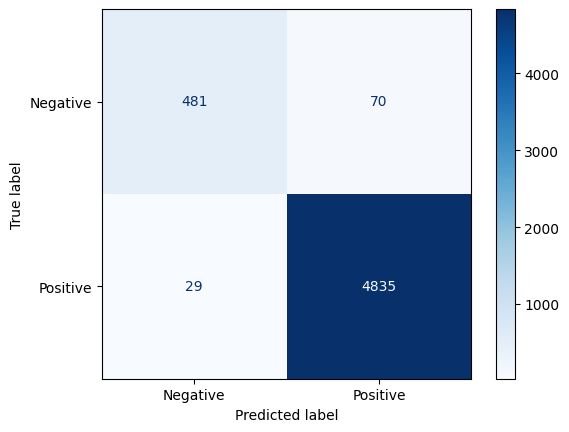

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Run predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Plot
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.show()


## Evaluate wrong predictions

In [25]:
# Run prediction
val_output = trainer.predict(val_dataset)

# Predicted class IDs
preds = val_output.predictions.argmax(axis=1)

# True class labels
true = val_output.label_ids


# Get the indices where predictions ≠ true labels
wrong_indices = np.where(preds != true)[0]
print(f"Number of misclassified samples: {len(wrong_indices)}")

# Convert integer IDs back to sentiment labels
id2label = {0: "negative", 1: "positive"}

# Print a few wrong predictions
for i in wrong_indices[:5]:  # show first 5
    print(f"\n--- Example #{i} ---")
    print(f"Text: {val_texts[i][:500]}")  # Print first 500 chars
    print(f"Actual: {id2label[true[i]]}, Predicted: {id2label[preds[i]]}")


Number of misclassified samples: 99

--- Example #12 ---
Text: Great tablet but not for everything: Fast working tablet but very limited on apps. I like it but it was not really for me. Only apps available were from the Amazon app store so many apps that I hoped to use were unavailable. So it is good for limited use.
Actual: positive, Predicted: negative

--- Example #52 ---
Text: Nice and compact: The HD tablet is just right for a child who is being introduced to the computer word.
Actual: negative, Predicted: positive

--- Example #187 ---
Text: returned item: Didn't want to go to the sites amazon wanted me to.
Actual: negative, Predicted: positive

--- Example #329 ---
Text: About 30 less life as other brand - but price is hard to ignore: Use these in a wireless BT mouse. Has about 30 less life as copper top brand. Good price, but most likely will not buy again.
Actual: negative, Predicted: positive

--- Example #457 ---
Text: Decent tablet.: Good tablet althought the availability o